## Suggested workflow

    [] Get the data for materials with both elastic properties and ones without
    [] Train a model using materials data with elastic props
    [] Test my model with materials having calculated elastic properties
    [] Plot the results for a perspective on the accuracies
    [] Then use the model to predict the elastic props of materials without
    [] Plot the results to get a feel of the magnitude of the predicted elastic props
    [] Get a select few of the materials with predicted high props and study more


### Step 1: Get the data for materials with both elastic properties and ones without

In [1]:
import os, sys, random
from numpy import mat
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifParser, CifFile
import json
import csv
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

%matplotlib inline


In [2]:
API_TOKEN = os.environ.get("MPTOKEN")
DATA_PATH = ""
SCRIPT_PATH = ""
ROOT_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])
EPOCHS = 20


In [9]:
## Contact the materials database API and get all Tarnery materials in the database
## - Will filter for the Metals and Nitrates later

try:
    with open(os.path.join(ROOT_DIR, "candidates.json"), 'r') as fo:
        print(f"Found candidates json file, using data from it...")
        materials = json.load(fo)

except Exception as e:
    print(f"Could not get candidates json file, getting data and creating cson file")
    
    mpr = MPRester(API_TOKEN)
    # mpr.materials.available_fields

    crt = {
        # 'elements': {'$all': ['N']},
        'nelements': 3,
        # 'band_gap': {'$lt': 1},
    }
    prt = ['material_id', 'pretty_formula', 'full_formula', 'band_gap', 
            'unit_cell_formula', 'elements', 'elasticity', 'cif', 'icsd_ids']

    materials = mpr.query(criteria=crt, properties=prt)

    with open(os.path.join(ROOT_DIR, "candidates.json"), 'w') as fo:
        json.dump(materials, fo, indent=2)

Found candidates json file, using data from it...


In [4]:
print([x['pretty_formula'] for x in materials[:20]])

['AcEuAu2', 'NiAgSe2', 'PrSiAg', 'Cd(AgI2)2', 'RbAg3Se2', 'CrAgS2', 'CaAgBi', 'AgPPd5', 'TmAgTe2', 'TmAgS2', 'CeMgAg', 'YSiAg', 'TlAgPd2', 'CaInAg2', 'CaCdAg2', 'ZrAgHg2', 'NaAg2Pd', 'LiAgPd2', 'Ba2CdAg', 'AgPd2Au']


In [11]:
CANDIDATES_WITH = []  # A list of candidate materials with ealstic props
CANDIDATES_WITHOUT = [] # A list of candidate materials without ealstic props
TMN_MATERIALS = []

for mat in materials:
    
    if mat['elasticity'] is None:
        CANDIDATES_WITHOUT.append(mat)
    else:
        CANDIDATES_WITH.append(mat)

with open(os.path.join(ROOT_DIR, "TMR_Data.json"), 'r') as fo:
    tmn_materials = json.load(fo)
    TMN_MATERIALS = tmn_materials.get('candidates')
    

print(f"Total Candidates: {len(materials)}")
print(f"Candidated found with elastic props: {len(CANDIDATES_WITH)}")
print(f"Candidated found without elastic props: {len(CANDIDATES_WITHOUT)}")
print(f"Total TMN materials: {len(TMN_MATERIALS)}")

Total Candidates: 59023
Candidated found with elastic props: 7372
Candidated found without elastic props: 51651
Total TMN materials: 2236


### Step 2: Train a model using materials data with elastic props
##### Step 2.1 Create The Training data

In [6]:
ID_PROPS_DATA = []

## Create CIF files
print(f"Creating CIF files...")
for i in CANDIDATES_WITH:
    
    mat_name = f"{i['pretty_formula']}_{i['material_id']}"
    bulk_modulus = i['elasticity']['K_VRH']

    with open(os.path.join(ROOT_DIR, f"src/data/{mat_name}.cif"), 'w') as fo:
        fo.write(i['cif'])

    ## Create ID Properties csv file data
    ID_PROPS_DATA.append([mat_name, bulk_modulus])
    
## Create ID Properties csv file
print(f"Creating ID Properties csv file...")
with open(os.path.join(ROOT_DIR, f"src/data/id_prop.csv"), 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)

## Create atom Init json file
print(f"Creating atom Init json file...")
with open(os.path.join(ROOT_DIR, f"atom_init.json"), 'r') as fr:
    with open(os.path.join(ROOT_DIR, "src/data/atom_init.json"), 'w') as fw:
        json.dump(json.load(fr), fw, indent=2)

print(f"Done creating training data.")




Creating CIF files...
Creating ID Properties csv file...
Creating atom Init json file...
Done creating training data.


##### Step 2.2 Train the model

In [9]:
main_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/main.py")
data_file = os.path.join(ROOT_DIR, "src/data")

run_options = f"--train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs {EPOCHS}"


cmd = f"python \"{main_file}\" {run_options} \"{data_file}\""
# cmd = "python -c print('Hello-world')"
print(cmd)

process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

out, err = process.communicate()
print(f"OUTPUT >> {out.decode('utf-8')}")
print(f"ERROR >> {err.decode('utf-8')}")
# print(result.decode("utf-8"))


python "c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/main.py" --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs 20 "c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/data"
OUTPUT >> Epoch: [0][0/18]	Time 6.750 (6.750)	Data 5.749 (5.749)	Loss 3.3729 (3.3729)	MAE 117.867 (117.867)
Epoch: [0][10/18]	Time 4.590 (5.257)	Data 3.603 (4.058)	Loss 0.8073 (3.0405)	MAE 48.669 (94.539)
Test: [0/6]	Time 4.679 (4.679)	Loss 0.8847 (0.8847)	MAE 57.510 (57.510)
 * MAE 56.231
Epoch: [1][0/18]	Time 0.972 (0.972)	Data 0.028 (0.028)	Loss 0.8769 (0.8769)	MAE 56.798 (56.798)
Epoch: [1][10/18]	Time 1.508 (1.101)	Data 0.021 (0.015)	Loss 0.5600 (0.7736)	MAE 44.885 (51.831)
Test: [0/6]	Time 0.250 (0.250)	Loss 0.6272 (0.6272)	MAE 37.322 (37.322)
 * MAE 32.684
Epoch: [2][0/18]	Time 1.069 (1.069)	Data 0.021 (0.021)	Loss 0.5012 (0.5012)	MAE 30.793 (30.793)
Epoch: [2][10/18]	Time 1.023 (1.170)	Data 0.014 (0.015)	Loss 0.2106 (0.2784)	MAE 23.562 (26.393)
T

             material  test      result   Unnamed: 3
0  Nd(PdO2)2_mp-15051   147  146.981110  0.000128506
1    VZnO3_mp-1016931   178  178.040085  0.000225196
2   SmHoZn2_mp-978537    58   57.981445  0.000319908
3      PrAlO3_mp-8218   194  194.068146  0.000351267
4   Ho2IrRh_mp-864625   125  125.060242  0.000481934
Working on the scatter plot...
Done creating plots


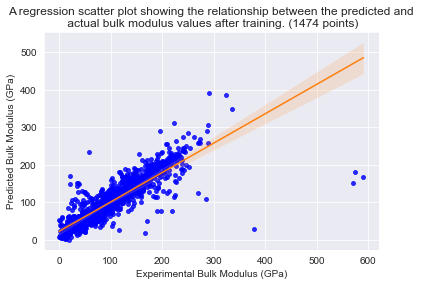

In [6]:
# result_file = os.path.join(ROOT_DIR, "src/test_results.csv")
result_file = os.path.join(ROOT_DIR, "src/test_results_publish.csv")

df = pd.read_csv(result_file)

df.dropna(subset=['material'], inplace=True)

print(df.head())

## Plot the scatter plot
print(f"Working on the scatter plot...")
color_dict = dict({'test':'brown',
                  'result':'green'})

sb.set_style("darkgrid")
ax = sb.regplot(x='test', y='result', data=df, line_kws={"color": "C1", 'linewidth': 1.5}, scatter_kws={'color': 'blue', 's': 15})
# ax = sb.scatterplot(x="test", y="result", data=df, palette=color_dict, legend='full')
ax.set_title(f"A regression scatter plot showing the relationship between the predicted and\n actual bulk modulus values after training. ({len(df)} points)")
ax.set_xlabel("Experimental Bulk Modulus (GPa)")
ax.set_ylabel("Predicted Bulk Modulus (GPa)")


print("Done creating plots")

#### 2.2.1 Create scatter plots showing perfomeance of the model for TMNs

mp-1097065


Text(0, 0.5, 'Predicted Bulk Modulus (GPa)')

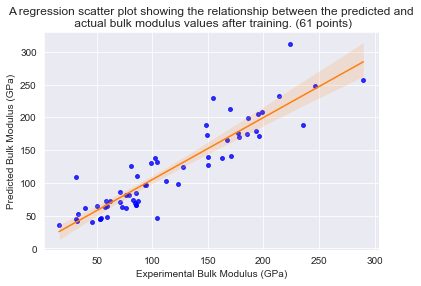

In [21]:
# Split the 'material' column into 'material_formula' and 'material_id'
df[['material_formula', 'material_id']] = df['material'].str.split('_', expand=True)
df.head()

# get a list of tmn material ids
tmn_material_ids = [m.get('material_id') for m in TMN_MATERIALS]
print(tmn_material_ids[0])

# Filter the DataFrame based on 'material_id'
filtered_df = df[df['material_id'].isin(tmn_material_ids)]

# Remove the 'material_formula' and 'material_id' columns
filtered_df = filtered_df.drop(['material_formula', 'material_id'], axis=1)

sb.set_style("darkgrid")
ax = sb.regplot(x='test', y='result', data=filtered_df, line_kws={"color": "C1", 'linewidth': 1.5}, scatter_kws={'color': 'blue', 's': 15})
# ax = sb.scatterplot(x="test", y="result", data=df, palette=color_dict, legend='full')
ax.set_title(f"A regression scatter plot showing the relationship between the predicted and\n actual bulk modulus values after training. ({len(filtered_df)} points)")
ax.set_xlabel("Experimental Bulk Modulus (GPa)")
ax.set_ylabel("Predicted Bulk Modulus (GPa)")


#### 2.2.2 Create scatter plots showing perfomeance of the model for non TMNs

mp-1097065


Text(0, 0.5, 'Predicted Bulk Modulus (GPa)')

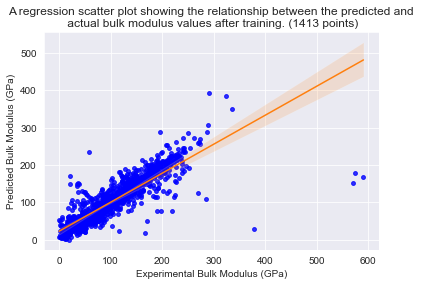

In [23]:
# Split the 'material' column into 'material_formula' and 'material_id'
df[['material_formula', 'material_id']] = df['material'].str.split('_', expand=True)
df.head()

# get a list of tmn material ids
tmn_material_ids = [m.get('material_id') for m in TMN_MATERIALS]
print(tmn_material_ids[0])

# Filter the DataFrame based on 'material_id'
filtered_df = df[~df['material_id'].isin(tmn_material_ids)]

# Remove the 'material_formula' and 'material_id' columns
filtered_df = filtered_df.drop(['material_formula', 'material_id'], axis=1)

sb.set_style("darkgrid")
ax = sb.regplot(x='test', y='result', data=filtered_df, line_kws={"color": "C1", 'linewidth': 1.5}, scatter_kws={'color': 'blue', 's': 15})
# ax = sb.scatterplot(x="test", y="result", data=df, palette=color_dict, legend='full')
ax.set_title(f"A regression scatter plot showing the relationship between the predicted and\n actual bulk modulus values after training. ({len(filtered_df)} points)")
ax.set_xlabel("Experimental Bulk Modulus (GPa)")
ax.set_ylabel("Predicted Bulk Modulus (GPa)")


### Step 3: Test my model with materials having calculated elastic properties

##### 3.1 Create data folder for prediction

{'material_id': 'mp-1065204',
 'pretty_formula': 'CrAgS2',
 'full_formula': 'Cr1Ag1S2',
 'band_gap': 0.0,
 'unit_cell_formula': {'Cr': 1.0, 'Ag': 1.0, 'S': 2.0},
 'elements': ['Ag', 'Cr', 'S'],
 'elasticity': None,
 'cif': "# generated using pymatgen\ndata_CrAgS2\n_symmetry_space_group_name_H-M   'P 1'\n_cell_length_a   7.46347352\n_cell_length_b   7.46347352\n_cell_length_c   7.46347408\n_cell_angle_alpha   26.53864030\n_cell_angle_beta   26.53864030\n_cell_angle_gamma   26.53864597\n_symmetry_Int_Tables_number   1\n_chemical_formula_structural   CrAgS2\n_chemical_formula_sum   'Cr1 Ag1 S2'\n_cell_volume   73.15966386\n_cell_formula_units_Z   1\nloop_\n _symmetry_equiv_pos_site_id\n _symmetry_equiv_pos_as_xyz\n  1  'x, y, z'\nloop_\n _atom_site_type_symbol\n _atom_site_label\n _atom_site_symmetry_multiplicity\n _atom_site_fract_x\n _atom_site_fract_y\n _atom_site_fract_z\n _atom_site_occupancy\n  Cr  Cr0  1  0.85721000  0.85721000  0.85721000  1\n  Ag  Ag1  1  0.01401800  0.01401800  

In [12]:
## Get the number of Ternary metal nitride materials in the dataset that dont have elastic properties
count = 0
for material in CANDIDATES_WITHOUT:

    ## Filter through only metal nitrides
    if material['band_gap'] < 1:
        continue
    
    if 'N' not in material['elements']:
        continue

    count += 1

print(f"Number of T.M.N materials without elastic properties {count} out of {len(CANDIDATES_WITHOUT)}")

Number of T.M.N materials without elastic properties 1176 out of 51651


In [15]:
ID_PROPS_DATA = []



## Create CIF files for materials without elastic props
print(f"Creating CIF files...")
_CANDIDATES_WITHOUT = random.choices(CANDIDATES_WITHOUT, k=20)
for i in CANDIDATES_WITHOUT:

    ## Filter through only metal nitrides
    if i['band_gap'] < 1:
        continue
    
    if 'N' not in i['elements']:
        continue
    
    mat_name = f"{i['pretty_formula']}_{i['material_id']}" # String Formatting
    bulk_modulus = random.randint(1, 999)

    with open(os.path.join(ROOT_DIR, f"src/data_predict/{mat_name}.cif"), 'w') as fo:
        fo.write(i['cif'])

    ## Create ID Properties csv file data
    ID_PROPS_DATA.append([mat_name, bulk_modulus])
    
## Create ID Properties csv file
print(f"Creating ID Properties csv file...")
with open(os.path.join(ROOT_DIR, f"src/data_predict/id_prop.csv"), 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)

## Create atom Init json file
print(f"Creating atom Init json file...")
with open(os.path.join(ROOT_DIR, f"atom_init.json"), 'r') as fr:
    with open(os.path.join(ROOT_DIR, "src/data_predict/atom_init.json"), 'w') as fw:
        json.dump(json.load(fr), fw, indent=2)

print(f"Done creating predicting data.")

Creating CIF files...
Creating ID Properties csv file...
Creating atom Init json file...
Done creating predicting data.


In [16]:

main_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/main.py")
predict_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/predict.py")
data_file = os.path.join(ROOT_DIR, "src/data_predict")
bulk_model = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/pre-trained/bulk-moduli.pth.tar")
my_model = os.path.join(ROOT_DIR, "src/17.776MAE_model_best.pth.tar")
python_exe = os.path.join(ROOT_DIR, "venv/Scripts/python.exe")

# EPOCHS = 30
# run_options = f"--train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs {EPOCHS}"


cmd = f"python \"{predict_file}\" \"{my_model}\" \"{data_file}\""
print(cmd)

process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

out, err = process.communicate()
print(f"OUTPUT >> {out.decode('utf-8')}")
print(f"ERRORS >> {err.decode('utf-8')}")

python "D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/predict.py" "D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar" "D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/data_predict"
OUTPUT >> => loading model params 'D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loaded model params 'D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loading model 'D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loaded model 'D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar' (epoch 17, validation 15.8565092086792)
Test: [0/5]	Time 17.946 (17.946)	Loss 49.1677 (49.1677)	MAE 403.206 (403.206)
 ** MAE 420.651

ERRORS >> D:\Projects a

In [33]:
result_file = os.path.join(ROOT_DIR, "src/predict_results.csv")

df = pd.read_csv(result_file)
df = df[['material', 'result']]
df = df.sort_values(by='result', ascending=False)

df = pd.DataFrame([(i[0].split('_')[0], i[0].split('_')[1], i[1]) for i in df.values], columns=['material', 'material_id', 'prediction'])

print(df)
df.to_csv('predictions.csv', index=False, header=True)
# print(df.head())

# ax = sb.scatterplot(x="material", y="result", data=df[:50], legend='full')
# small_df = df[:50]
# print(df)

# print(f"Working on the bar plot...")
# width = int((small_df.shape[0] * 3) / 5)
# print(f"Widht = {width}")
# ax = small_df.plot(x="material", y="result", kind='bar', figsize=(width, 7),
#                 title=f"Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [TOTAL-CANDIDATES={small_df.shape[0]}]",
#                 )

# ax.set_xlabel("Material")
# ax.set_ylabel("Predicted Bulk Modulus (GPa)")

# print("Done creating plots")

# print(f"Working on the bar plot 2...")
# width = int((df.shape[0] * 3) / 5)
# print(f"Widht = {width}")
# ax = df.plot(x="material", y="result", kind='bar', figsize=(width, 7),
#                 title=f"Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [TOTAL-CANDIDATES={df.shape[0]}]",
#                 )

# ax.set_xlabel("Material")
# ax.set_ylabel("Predicted Bulk Modulus (GPa)")

print("Done creating plots")

      material material_id  prediction
0     B2(CN2)3   mp-989468  473.001251
1     B2(CN2)3   mp-989466  434.544800
2      SrC7N10  mp-1245820  426.541809
3      CaC7N10  mp-1247296  426.433441
4      PbC7N10  mp-1246015  426.148773
...        ...         ...         ...
1171     SeNO4  mp-1209541  -24.504280
1172      SNF3  mp-1209117  -26.591362
1173    C2N2O5  mp-1188168  -26.881630
1174      PNO4  mp-1190793  -33.079399
1175    C2N2O5  mp-1182116  -34.010277

[1176 rows x 3 columns]
Done creating plots


##### Show Performance of the model on well known materials

In [34]:
## Get the properties for the common materials
mpr = MPRester(API_TOKEN)

crt = {
    'material_id': {'$in': ['mp-66', 'mp-984', 'mp-492', 'mp-631']}
}
prt = ['material_id', 'pretty_formula', 'full_formula', 'band_gap', 
        'unit_cell_formula', 'elements', 'elasticity', 'cif', 'icsd_ids']

materials = mpr.query(criteria=crt, properties=prt)

In [35]:
for m in materials: print(m['pretty_formula'])

TiN
TiC
C
BN


In [37]:
ID_PROPS_DATA = []
## Create CIF files for materials without elastic props
print(f"Creating CIF files...")
for i in materials:
    
    mat_name = f"{i['pretty_formula']}_{i['material_id']}"
    bulk_modulus = random.randint(1, 999)

    with open(os.path.join(ROOT_DIR, f"src/data_common/{mat_name}.cif"), 'w') as fo:
        fo.write(i['cif'])

    ## Create ID Properties csv file data
    ID_PROPS_DATA.append([mat_name, bulk_modulus])
    
## Create ID Properties csv file
print(f"Creating ID Properties csv file...")
with open(os.path.join(ROOT_DIR, f"src/data_common/id_prop.csv"), 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)

## Create atom Init json file
print(f"Creating atom Init json file...")
with open(os.path.join(ROOT_DIR, f"atom_init.json"), 'r') as fr:
    with open(os.path.join(ROOT_DIR, "src/data_common/atom_init.json"), 'w') as fw:
        json.dump(json.load(fr), fw, indent=2)

print(f"Done creating predicting data.")

Creating CIF files...
Creating ID Properties csv file...
Creating atom Init json file...
Done creating predicting data.


In [38]:

predict_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/predict.py")
data_file = os.path.join(ROOT_DIR, "src/data_common")
my_model = os.path.join(ROOT_DIR, "src/17.776MAE_model_best.pth.tar")
paper_model = os.path.join(ROOT_DIR, "src/cgcnn-master/pre-trained/bulk-moduli.pth.tar")

cmd = f"python \"{predict_file}\" \"{my_model}\" \"{data_file}\""
print(cmd)

process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

out, err = process.communicate()
print(f"OUTPUT >> {out.decode('utf-8')}")
print(f"ERRORS >> {err.decode('utf-8')}")

python "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/predict.py" "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar" "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/data_common"
OUTPUT >> => loading model params 'd:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loaded model params 'd:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loading model 'd:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loaded model 'd:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar' (epoch 17, validation 15.8565092086792)
Test: [0/1]	Time 1.149 (1.149)	Loss 17.2204 (17.2204)	MAE 237.579 (237.579)
 ** MAE 237.579

ERRORS >> d:\Projects and 

     material  experimental   predicted
0     C_mp-66         436.0  343.799316
3  TiN_mp-492         259.0  217.655197
1  TiC_mp-631         253.0  189.237122
2   BN_mp-984         103.0  287.590332
Working on the bar plot...
Widht = 0
Done creating plots


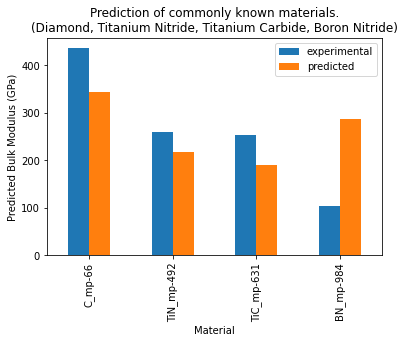

In [48]:
result_file = os.path.join(ROOT_DIR, "src/predict_common_publish.csv")

df = pd.read_csv(result_file)
# df = df.sort_values(by='test', ascending=False)

lis = []
for i in df.to_dict(orient='split')['data']:
    result_dict = {}
    for j in materials:
        if j['material_id'] in i[0]:
            result_dict['material'] = i[0]
            result_dict['experimental'] = j['elasticity']['K_VRH']
            result_dict['predicted'] = i[-1]
        
    lis.append(result_dict)

df = pd.DataFrame(lis)
df = df.sort_values(by='experimental', ascending=False)
    
print(df)

print(f"Working on the bar plot...")
width = int((df.shape[0] * 1) / 5)
print(f"Widht = {width}")
ax = df.plot(x="material", y=["experimental", "predicted"], kind='bar',
        title=f"Prediction of commonly known materials.\n(Diamond, Titanium Nitride, Titanium Carbide, Boron Nitride)",
        )
ax.set_xlabel("Material")
ax.set_ylabel("Predicted Bulk Modulus (GPa)")

print("Done creating plots")

In [49]:
## Get the properties for the common materials
mpr = MPRester(API_TOKEN)
# mpr.materials.available_fields

crt = {
        'elements': {'$all': ['O']},
        'nelements': 3,
        # 'band_gap': {'$lt': 1},
    }
prt = ['material_id', 'pretty_formula', 'full_formula', 'band_gap', 
            'unit_cell_formula', 'elements', 'elasticity','icsd_ids']

materials = mpr.query(criteria=crt, properties=prt)

100%|██████████| 21698/21698 [01:34<00:00, 228.42it/s]


In [52]:
e_ovac_materials = [m for m in materials if 'O3' in m['pretty_formula']]

In [55]:
print(len(e_ovac_materials))
e_ovac_materials[0]

4396


{'material_id': 'mp-1011260',
 'pretty_formula': 'EuFeO3',
 'full_formula': 'Eu2Fe2O6',
 'band_gap': 0.0,
 'unit_cell_formula': {'Eu': 2.0, 'Fe': 2.0, 'O': 6.0},
 'elements': ['Eu', 'Fe', 'O'],
 'elasticity': None,
 'icsd_ids': []}